<a href="https://colab.research.google.com/github/esraa9322/Deep_Active_Learning_DeepAL/blob/main/Deep_Active_Learning_using_DeepAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports ,Installations and Setup**

In [ ]:
! pip3 install torch torchvision torchaudio 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import sys
import numpy as np 
import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torchvision
import os

from random import randrange
from functools import partial
from torchvision import datasets,transforms
from torch import nn
from tqdm import tqdm 
from torch.nn.modules import transformer
from torchvision import transforms

In [ ]:
!git clone https://github.com/ej0cl6/deep-active-learning

fatal: destination path 'deep-active-learning' already exists and is not an empty directory.


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
os.chdir('/content/deep-active-learning')

sys.path.append('/content/deep-active-learning') 

In [ ]:
with open('/content/deep-active-learning/data.py', 'r') as f:
    DATA = f.read()
exec(DATA)

with open('/content/deep-active-learning/handlers.py', 'r') as f:
    Handler = f.read()
exec(Handler)
with open('/content/deep-active-learning/nets.py', 'r') as f:
    Nets = f.read()
exec(Nets)

# **CIFAR10 Dataset Loading and Visualization**

In the following section CIFAR10 dataset is loaded from pytorch built-in libraries, then visualized in a way that showes how balanced it is , then the class CIFAR10NET is initialized which contains the default convolutional architecture for CIFAR10 dataset in deepAL library , also it's most important parameters are initialized  

In [ ]:
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transforms.ToTensor()
)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transforms.ToTensor() 
) 

100%|██████████| 170498071/170498071 [00:13<00:00, 12926104.95it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
IDX_TO_LABEL = {v: k for k, v in trainset.class_to_idx.items()} 

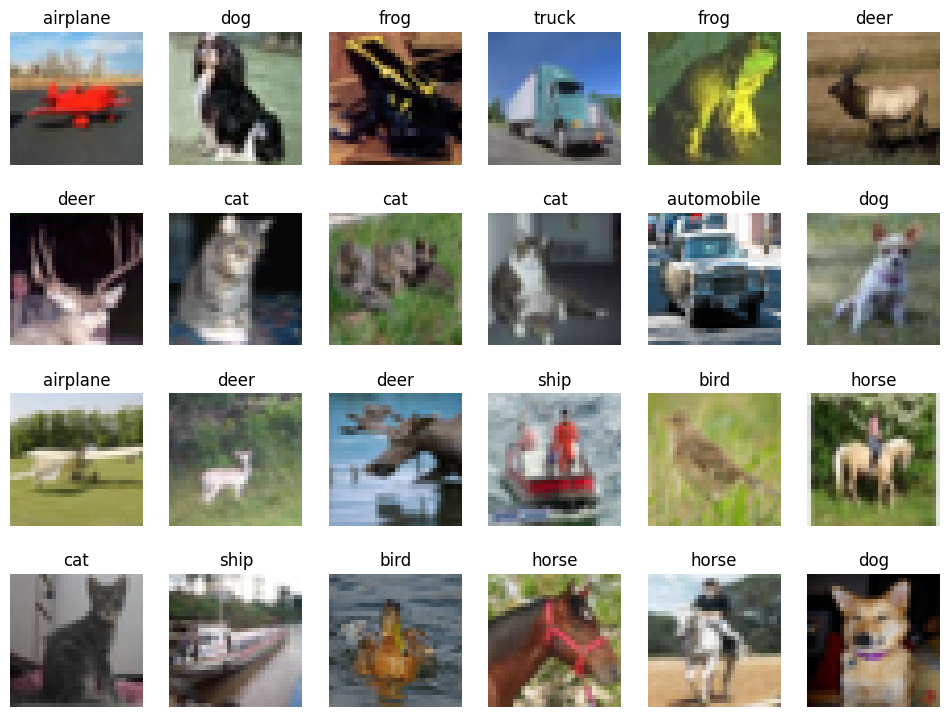

In [ ]:
cols = 6
rows = 4
fig, axs = plt.subplots(rows, cols, figsize=(12, 9))

for x in range(rows):
    for y in range(cols):
        rnd_idx = randrange(len(trainset.data))
        
        axs[x, y].set_title(IDX_TO_LABEL[trainset.targets[rnd_idx]])
        axs[x, y].imshow(trainset.data[rnd_idx])
        axs[x, y].set_axis_off()

plt.show()   

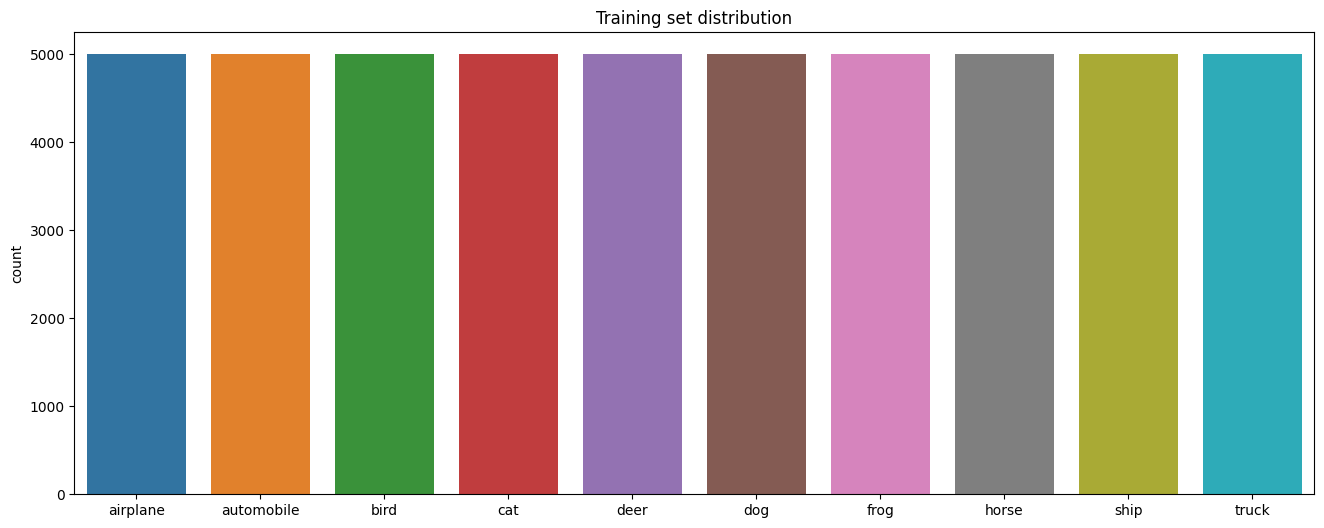

In [ ]:
fig, ax = plt.subplots(figsize=(16, 6))

sns.countplot(
    x=pd.Series(trainset.targets).map(IDX_TO_LABEL), 
    order=IDX_TO_LABEL.values(),
).set_title('Training set distribution')

plt.show()


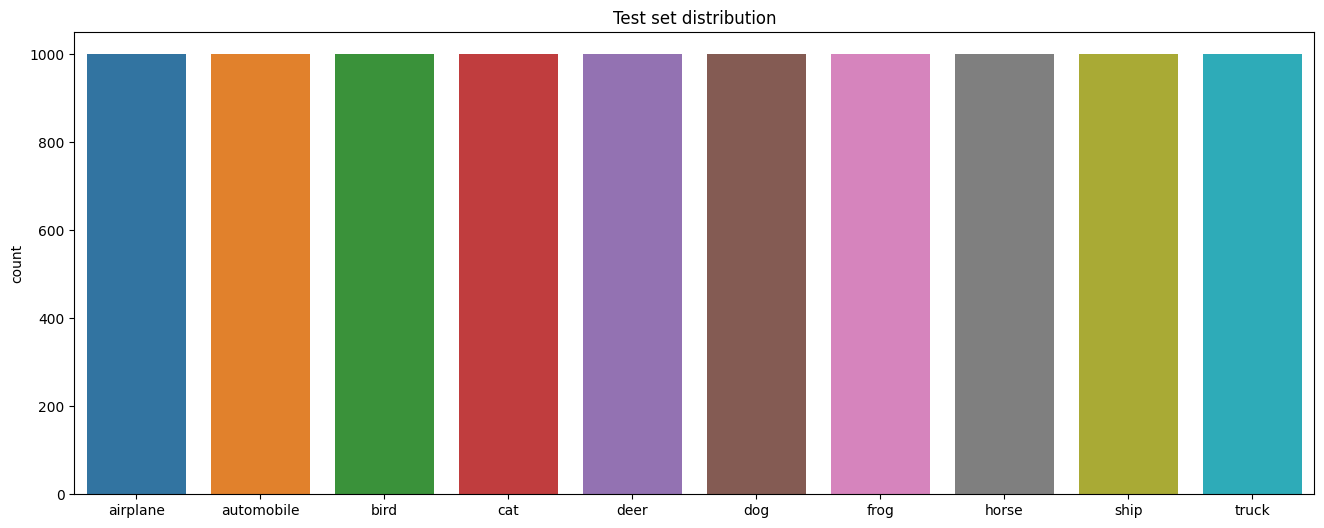

In [ ]:
fig, ax = plt.subplots(figsize=(16, 6))

sns.countplot(
    x=pd.Series(testset.targets).map(IDX_TO_LABEL), 
    order=IDX_TO_LABEL.values(),
).set_title('Test set distribution')

plt.show() 

In [ ]:
#load dataset
dataset1=Data(trainset.data[:40000], torch.LongTensor(trainset.targets)[:40000], testset.data[:40000], torch.LongTensor(testset.targets)[:40000], CIFAR10_Handler)

In [ ]:
class CIFAR10_Net(nn.Module):
    def __init__(self):
        super(CIFAR10_Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(1024, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = x.view(-1, 1024)
        e1 = F.relu(self.fc1(x))
        x = F.dropout(e1, training=self.training)
        x = self.fc2(x)
        return x, e1
    def get_embedding_dim(self):
        return 50

In [ ]:
# defining parameters of the net 
CIFAR10={'n_epoch': 20, 
               'train_args':{'batch_size': 64, 'num_workers': 1},
               'test_args':{'batch_size': 1000, 'num_workers': 1},
               'optimizer_args':{'lr': 0.05, 'momentum': 0.3}}
# load network 
net= Net(CIFAR10_Net, CIFAR10, device)                

# **Testing different Strategies on CIFAR10 dataset**

In [ ]:
from query_strategies.strategy import Strategy 
from query_strategies.margin_sampling import MarginSampling 
from query_strategies.entropy_sampling import EntropySampling
from query_strategies.least_confidence import LeastConfidence
from query_strategies.random_sampling import RandomSampling

In [ ]:
strategy1=RandomSampling(dataset1,net)
strategy2=MarginSampling(dataset1,net)
strategy3=EntropySampling(dataset1,net)
strategy4=LeastConfidence(dataset1,net)

In [ ]:
##### RANDOM SAMPLING STRATEGY
for rd in range(1,11):
    print(f"Round {rd}")

    # query
    query_idxs = strategy1.query(500)

    # update labels
    strategy1.update(query_idxs)
    strategy1.train()

    # calculate accuracy
    preds = strategy1.predict(dataset1.get_test_data())
    print(f"Round {rd} testing accuracy: {dataset1.cal_test_acc(preds)}") 

Round 1


100%|███████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.73it/s]


Round 1 testing accuracy: 0.2731
Round 2


100%|███████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.15it/s]


Round 2 testing accuracy: 0.3442
Round 3


100%|███████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.56it/s]


Round 3 testing accuracy: 0.3842
Round 4


100%|███████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.23it/s]


Round 4 testing accuracy: 0.3863
Round 5


100%|███████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.02s/it]


Round 5 testing accuracy: 0.3583
Round 6


100%|███████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.18s/it]


Round 6 testing accuracy: 0.4529
Round 7


100%|███████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.37s/it]


Round 7 testing accuracy: 0.4706
Round 8


100%|███████████████████████████████████████████████████████████████| 20/20 [00:30<00:00,  1.51s/it]


Round 8 testing accuracy: 0.4851
Round 9


100%|███████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.65s/it]


Round 9 testing accuracy: 0.4284
Round 10


100%|███████████████████████████████████████████████████████████████| 20/20 [00:37<00:00,  1.87s/it]


Round 10 testing accuracy: 0.5085


In [ ]:
##### MARGIN SAMPLING STRATEGY
for rd in range(1,11):
    print(f"Round {rd}")

    # query
    query_idxs = strategy2.query(500)

    # update labels
    strategy2.update(query_idxs)
    strategy2.train()

    # calculate accuracy
    preds = strategy2.predict(dataset1.get_test_data())
    print(f"Round {rd} testing accuracy: {dataset1.cal_test_acc(preds)}") 

Round 1


100%|███████████████████████████████████████████████████████████████| 20/20 [00:40<00:00,  2.04s/it]


Round 1 testing accuracy: 0.5129
Round 2


100%|███████████████████████████████████████████████████████████████| 20/20 [00:44<00:00,  2.24s/it]


Round 2 testing accuracy: 0.5471
Round 3


100%|███████████████████████████████████████████████████████████████| 20/20 [00:50<00:00,  2.54s/it]


Round 3 testing accuracy: 0.5311
Round 4


100%|███████████████████████████████████████████████████████████████| 20/20 [00:56<00:00,  2.84s/it]


Round 4 testing accuracy: 0.5042
Round 5


100%|███████████████████████████████████████████████████████████████| 20/20 [01:00<00:00,  3.00s/it]


Round 5 testing accuracy: 0.5249
Round 6


100%|███████████████████████████████████████████████████████████████| 20/20 [01:02<00:00,  3.15s/it]


Round 6 testing accuracy: 0.5521
Round 7


100%|███████████████████████████████████████████████████████████████| 20/20 [01:05<00:00,  3.29s/it]


Round 7 testing accuracy: 0.5776
Round 8


100%|███████████████████████████████████████████████████████████████| 20/20 [01:06<00:00,  3.32s/it]


Round 8 testing accuracy: 0.5408
Round 9


100%|███████████████████████████████████████████████████████████████| 20/20 [01:09<00:00,  3.49s/it]


Round 9 testing accuracy: 0.561
Round 10


100%|███████████████████████████████████████████████████████████████| 20/20 [01:13<00:00,  3.66s/it]


Round 10 testing accuracy: 0.5675


In [ ]:
##### ENTROPY SAMPLING STRATEGY
for rd in range(1,11):
    print(f"Round {rd}")

    # query
    query_idxs = strategy3.query(500)

    # update labels
    strategy3.update(query_idxs)
    strategy3.train()

    # calculate accuracy
    preds = strategy3.predict(dataset1.get_test_data())
    print(f"Round {rd} testing accuracy: {dataset1.cal_test_acc(preds)}") 

Round 1


100%|███████████████████████████████████████████████████████████████| 20/20 [01:16<00:00,  3.83s/it]


Round 1 testing accuracy: 0.4463
Round 2


100%|███████████████████████████████████████████████████████████████| 20/20 [01:19<00:00,  3.96s/it]


Round 2 testing accuracy: 0.5841
Round 3


100%|███████████████████████████████████████████████████████████████| 20/20 [01:23<00:00,  4.17s/it]


Round 3 testing accuracy: 0.5685
Round 4


100%|███████████████████████████████████████████████████████████████| 20/20 [01:26<00:00,  4.33s/it]


Round 4 testing accuracy: 0.5736
Round 5


100%|███████████████████████████████████████████████████████████████| 20/20 [01:29<00:00,  4.48s/it]


Round 5 testing accuracy: 0.5349
Round 6


100%|███████████████████████████████████████████████████████████████| 20/20 [01:33<00:00,  4.67s/it]


Round 6 testing accuracy: 0.5795
Round 7


100%|███████████████████████████████████████████████████████████████| 20/20 [01:36<00:00,  4.82s/it]


Round 7 testing accuracy: 0.5757
Round 8


100%|███████████████████████████████████████████████████████████████| 20/20 [01:40<00:00,  5.04s/it]


Round 8 testing accuracy: 0.6033
Round 9


100%|███████████████████████████████████████████████████████████████| 20/20 [01:43<00:00,  5.17s/it]


Round 9 testing accuracy: 0.6132
Round 10


100%|███████████████████████████████████████████████████████████████| 20/20 [01:47<00:00,  5.38s/it]


Round 10 testing accuracy: 0.6036


In [ ]:
##### LEAST CONFIDENCE STRATEGY
for rd in range(1,11):
    print(f"Round {rd}")

    # query
    query_idxs = strategy4.query(500)

    # update labels
    strategy4.update(query_idxs)
    strategy4.train()

    # calculate accuracy
    preds = strategy4.predict(dataset1.get_test_data())
    print(f"Round {rd} testing accuracy: {dataset1.cal_test_acc(preds)}") 

Round 1


100%|███████████████████████████████████████████████████████████████| 20/20 [01:51<00:00,  5.55s/it]


Round 1 testing accuracy: 0.6203
Round 2


100%|███████████████████████████████████████████████████████████████| 20/20 [01:54<00:00,  5.74s/it]


Round 2 testing accuracy: 0.6085
Round 3


100%|███████████████████████████████████████████████████████████████| 20/20 [01:58<00:00,  5.94s/it]


Round 3 testing accuracy: 0.6093
Round 4


100%|███████████████████████████████████████████████████████████████| 20/20 [02:01<00:00,  6.08s/it]


Round 4 testing accuracy: 0.6189
Round 5


100%|███████████████████████████████████████████████████████████████| 20/20 [02:05<00:00,  6.26s/it]


Round 5 testing accuracy: 0.6063
Round 6


100%|███████████████████████████████████████████████████████████████| 20/20 [02:08<00:00,  6.45s/it]


Round 6 testing accuracy: 0.5842
Round 7


100%|███████████████████████████████████████████████████████████████| 20/20 [02:12<00:00,  6.61s/it]


Round 7 testing accuracy: 0.5703
Round 8


100%|███████████████████████████████████████████████████████████████| 20/20 [02:16<00:00,  6.82s/it]


Round 8 testing accuracy: 0.6277
Round 9


100%|███████████████████████████████████████████████████████████████| 20/20 [02:19<00:00,  6.98s/it]


Round 9 testing accuracy: 0.6249
Round 10


100%|███████████████████████████████████████████████████████████████| 20/20 [02:22<00:00,  7.13s/it]


Round 10 testing accuracy: 0.6358


# **MNIST Dataset Loading and Visualization**

In [ ]:
#MNIST
trainset2 = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transforms.ToTensor()
)

testset2 = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transforms.ToTensor() 
) 

100%|██████████| 9912422/9912422 [00:00<00:00, 362764477.56it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 46716426.47it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 193138164.56it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6096169.21it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
IDX_TO_LABEL2 = {v: k for k, v in trainset2.class_to_idx.items()}

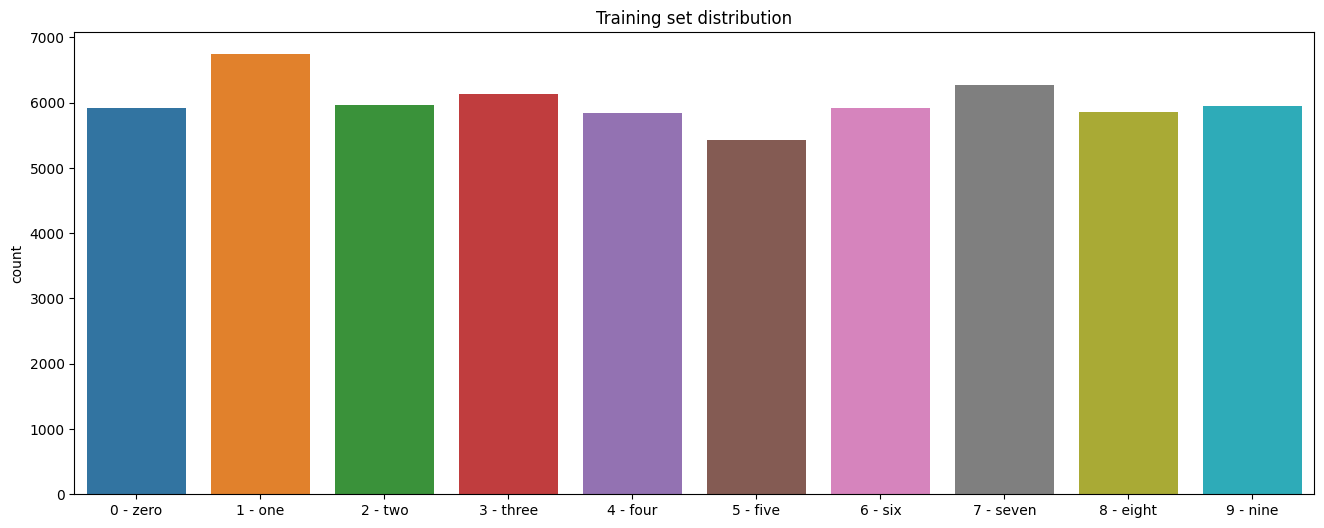

In [ ]:
fig, ax = plt.subplots(figsize=(16, 6))

sns.countplot(
    x=pd.Series(trainset2.targets).map(IDX_TO_LABEL2), 
    order=IDX_TO_LABEL2.values(),
).set_title('Training set distribution')

plt.show()


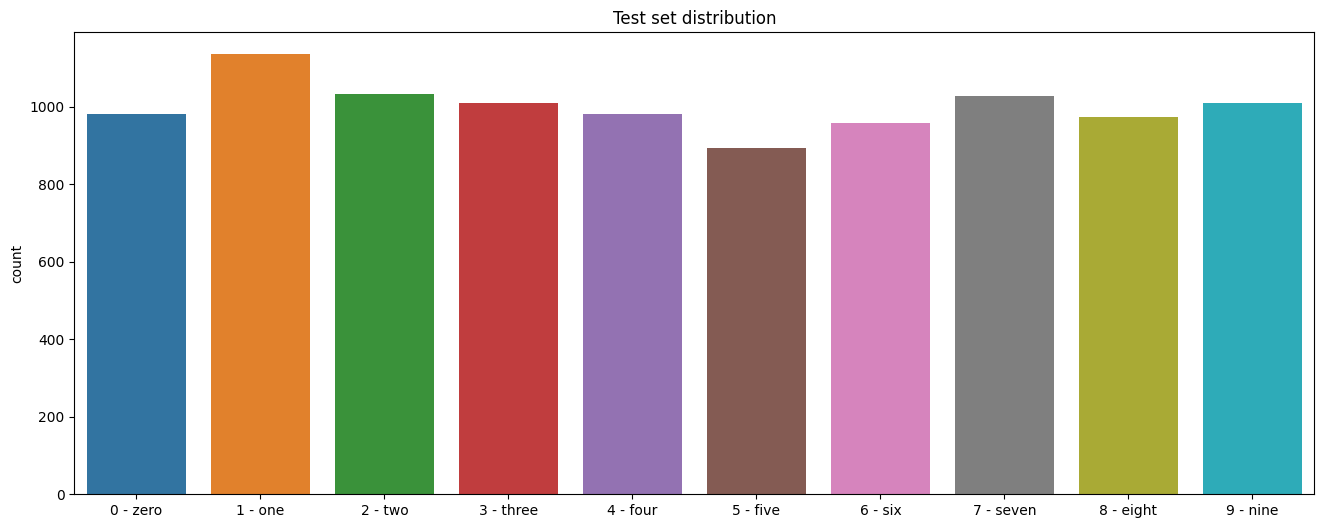

In [ ]:
fig, ax = plt.subplots(figsize=(16, 6))

sns.countplot(
    x=pd.Series(testset2.targets).map(IDX_TO_LABEL2), 
    order=IDX_TO_LABEL2.values(),
).set_title('Test set distribution')

plt.show() 

In [ ]:
import data

In [ ]:
dataset2b=get_MNIST(MNIST_Handler)

In [ ]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        e1 = F.relu(self.fc1(x))
        x = F.dropout(e1, training=self.training)
        x = self.fc2(x)
        return x, e1
    def get_embedding_dim(self):
        return 50

In [ ]:
#initializing net parameters
MNIST=     {'n_epoch': 10, 
               'train_args':{'batch_size': 64, 'num_workers': 1},
               'test_args':{'batch_size': 1000, 'num_workers': 1},
               'optimizer_args':{'lr': 0.01, 'momentum': 0.5}}

In [ ]:
net2= Net(MNIST_Net, MNIST, device)

# **Testing different strategies on MNIST dataset**

In [ ]:
strategy1b=RandomSampling(dataset2b,net2)
strategy2b=MarginSampling(dataset2b,net2)
strategy3b=EntropySampling(dataset2b,net2)
strategy4b=LeastConfidence(dataset2b,net2)

In [ ]:
##### RANDOM SAMPLING STRATEGY
for rd in range(1,11):
    print(f"Round {rd}")

    # query
    query_idxs = strategy1b.query(500)

    # update labels
    strategy1b.update(query_idxs)
    strategy1b.train()

    # calculate accuracy
    preds = strategy1b.predict(dataset2b.get_test_data())
    print(f"Round {rd} testing accuracy: {dataset2b.cal_test_acc(preds)}") 

Round 1


100%|███████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.90it/s]


Round 1 testing accuracy: 0.5307
Round 2


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.20it/s]


Round 2 testing accuracy: 0.7951
Round 3


100%|███████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.83it/s]


Round 3 testing accuracy: 0.8606
Round 4


100%|███████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.38it/s]


Round 4 testing accuracy: 0.8764
Round 5


100%|███████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.03s/it]


Round 5 testing accuracy: 0.9085
Round 6


100%|███████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.01s/it]


Round 6 testing accuracy: 0.9271
Round 7


100%|███████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


Round 7 testing accuracy: 0.9201
Round 8


100%|███████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.33s/it]


Round 8 testing accuracy: 0.9286
Round 9


100%|███████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.54s/it]


Round 9 testing accuracy: 0.937
Round 10


100%|███████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Round 10 testing accuracy: 0.9286


In [ ]:
##### MARGIN SAMPLING STRATEGY
for rd in range(1,11):
    print(f"Round {rd}")

    # query
    query_idxs = strategy2b.query(500)

    # update labels
    strategy2b.update(query_idxs)
    strategy2b.train()

    # calculate accuracy
    preds = strategy2b.predict(dataset2b.get_test_data())
    print(f"Round {rd} testing accuracy: {dataset2b.cal_test_acc(preds)}") 

Round 1


100%|███████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.78s/it]


Round 1 testing accuracy: 0.9488
Round 2


100%|███████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.48s/it]


Round 2 testing accuracy: 0.9521
Round 3


100%|███████████████████████████████████████████████████████████████| 10/10 [00:22<00:00,  2.23s/it]


Round 3 testing accuracy: 0.9642
Round 4


100%|███████████████████████████████████████████████████████████████| 10/10 [00:23<00:00,  2.31s/it]


Round 4 testing accuracy: 0.9596
Round 5


100%|███████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.41s/it]


Round 5 testing accuracy: 0.9664
Round 6


100%|███████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.54s/it]


Round 6 testing accuracy: 0.9679
Round 7


100%|███████████████████████████████████████████████████████████████| 10/10 [00:26<00:00,  2.67s/it]


Round 7 testing accuracy: 0.9715
Round 8


100%|███████████████████████████████████████████████████████████████| 10/10 [00:29<00:00,  2.91s/it]


Round 8 testing accuracy: 0.9656
Round 9


100%|███████████████████████████████████████████████████████████████| 10/10 [00:30<00:00,  3.03s/it]


Round 9 testing accuracy: 0.9745
Round 10


100%|███████████████████████████████████████████████████████████████| 10/10 [00:31<00:00,  3.20s/it]


Round 10 testing accuracy: 0.9741


In [ ]:
##### ENTROPY SAMPLING STRATEGY
for rd in range(1,11):
    print(f"Round {rd}")

    # query
    query_idxs = strategy3b.query(500)

    # update labels
    strategy3b.update(query_idxs)
    strategy3b.train()

    # calculate accuracy
    preds = strategy3b.predict(dataset2b.get_test_data())
    print(f"Round {rd} testing accuracy: {dataset2b.cal_test_acc(preds)}") 

Round 1


100%|███████████████████████████████████████████████████████████████| 10/10 [00:33<00:00,  3.31s/it]


Round 1 testing accuracy: 0.9714
Round 2


100%|███████████████████████████████████████████████████████████████| 10/10 [00:35<00:00,  3.57s/it]


Round 2 testing accuracy: 0.9792
Round 3


100%|███████████████████████████████████████████████████████████████| 10/10 [00:35<00:00,  3.56s/it]


Round 3 testing accuracy: 0.9774
Round 4


100%|███████████████████████████████████████████████████████████████| 10/10 [00:36<00:00,  3.68s/it]


Round 4 testing accuracy: 0.9756
Round 5


100%|███████████████████████████████████████████████████████████████| 10/10 [00:39<00:00,  3.91s/it]


Round 5 testing accuracy: 0.9757
Round 6


100%|███████████████████████████████████████████████████████████████| 10/10 [00:41<00:00,  4.14s/it]


Round 6 testing accuracy: 0.9782
Round 7


100%|███████████████████████████████████████████████████████████████| 10/10 [00:42<00:00,  4.23s/it]


Round 7 testing accuracy: 0.9792
Round 8


100%|███████████████████████████████████████████████████████████████| 10/10 [00:43<00:00,  4.37s/it]


Round 8 testing accuracy: 0.9804
Round 9


100%|███████████████████████████████████████████████████████████████| 10/10 [00:44<00:00,  4.47s/it]


Round 9 testing accuracy: 0.9792
Round 10


100%|███████████████████████████████████████████████████████████████| 10/10 [00:46<00:00,  4.61s/it]


Round 10 testing accuracy: 0.9769


In [ ]:
##### LEAST CONFIDENCE STRATEGY
for rd in range(1,11):
    print(f"Round {rd}")

    # query
    query_idxs = strategy4b.query(500)

    # update labels
    strategy4b.update(query_idxs)
    strategy4b.train()

    # calculate accuracy
    preds = strategy4b.predict(dataset2b.get_test_data())
    print(f"Round {rd} testing accuracy: {dataset2b.cal_test_acc(preds)}") 

Round 1


100%|███████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.09it/s]


Round 1 testing accuracy: 0.2979
Round 2


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.37it/s]


Round 2 testing accuracy: 0.5479
Round 3


100%|███████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.72it/s]


Round 3 testing accuracy: 0.7123
Round 4


100%|███████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.49it/s]


Round 4 testing accuracy: 0.8175
Round 5


100%|███████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.06it/s]


Round 5 testing accuracy: 0.8482
Round 6


100%|███████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.01s/it]


Round 6 testing accuracy: 0.8981
Round 7


100%|███████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.16s/it]


Round 7 testing accuracy: 0.9121
Round 8


100%|███████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.31s/it]


Round 8 testing accuracy: 0.9253
Round 9


100%|███████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.44s/it]


Round 9 testing accuracy: 0.9459
Round 10


100%|███████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.59s/it]


Round 10 testing accuracy: 0.9447
